<a href="https://colab.research.google.com/github/Tung0000/Object_custom_Yolov8/blob/main/Train_Custom_YoloV8_Drone_new_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#กำหนด Path ที่จะทำงานใน Colab

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


#ติดตั้ง Library ที่จำเป็น

In [ ]:
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 107.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


# สร้าง Folder รองรับ Dataset

In [ ]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

/content/datasets


#โหลด Dataset จาก Roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0100tTC6iSisNdselYOb")
project = rf.workspace("test-gaiza").project("drone-fm51j")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to drone-2 in yolov8:: 100%|██████████| 8416/8416 [00:01<00:00, 7490.26it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#  Train Model Yolo ด้วย Dataset ที่เตรียมไว้

In [ ]:
import ultralytics
from ultralytics import YOLO
%cd {HOME}
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs= 20 imgsz=800 plots=True

/content
Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/drone-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

#แสดงผลลัพธ์จากการ Train Model

## เตรียมฟังก์ชั่น แสดงรูปภาพ

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# ฟังก์ชันแสดงภาพด้วย matplotlib
def display_image(image_path, figsize=(10, 10)):
    """แสดงภาพโดยใช้ matplotlib"""
    if not os.path.exists(image_path):
        print(f"ไม่พบไฟล์ที่ {image_path}")
        return
    # โหลดภาพ
    image = cv2.imread(image_path)  # โหลดภาพด้วย OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # แปลงสี BGR เป็น RGB
    # แสดงผลภาพ
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')  # ปิดแกน
    plt.show()

##แสดง Confusion Metrix

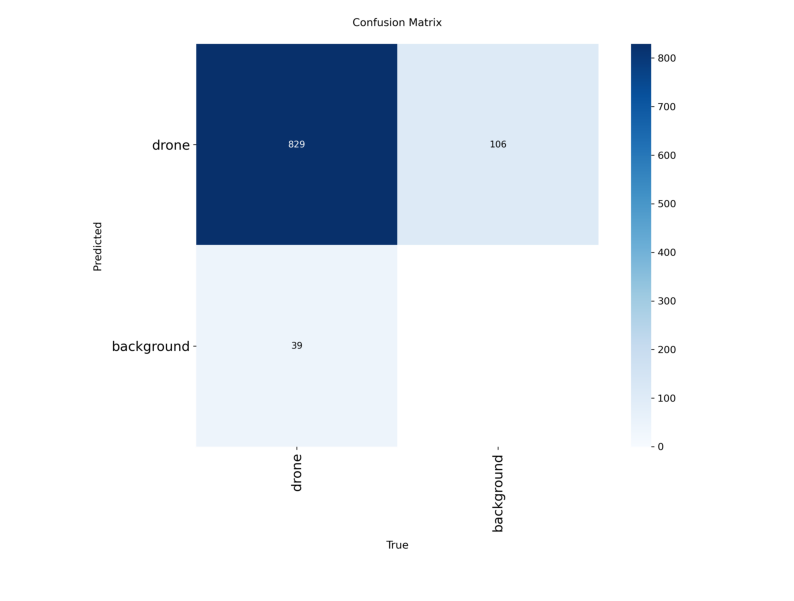

In [ ]:
# เส้นทางไฟล์ภาพ confusion_matrix
image_path = f"{HOME}/runs/detect/train/confusion_matrix.png"
# เรียกใช้ฟังก์ชันแสดงภาพ
display_image(image_path)

##แสดงภาพตัวอย่างที่ทำนายแล้ว จากการ Valid

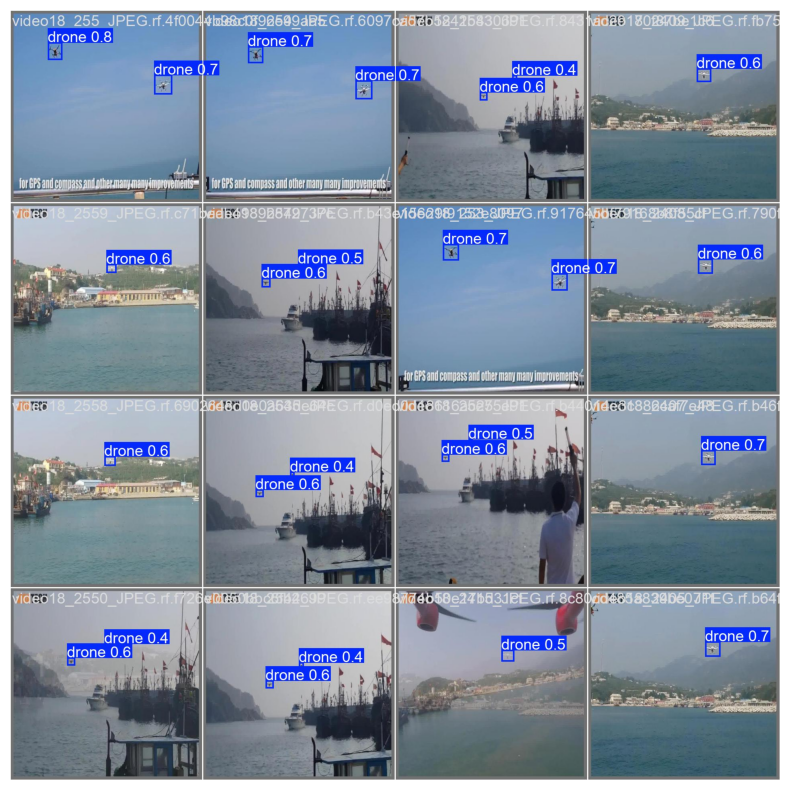

In [ ]:
# เส้นทางไฟล์ภาพจากการ Valid
image_path = f'{HOME}/runs/detect/train/val_batch0_pred.jpg'
# เรียกใช้ฟังก์ชันแสดงภาพ
display_image(image_path)

#ส่วนการลดขนาดmodel


In [ ]:
from ultralytics import YOLO

# โหลดโมเดลที่ train เสร็จ
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Export เป็น ONNX
model.export(format="onnx", opset=12)

# Export เป็น TFLite แบบ quantized INT8
model.export(format="tflite", int8=True)


In [ ]:
from google.colab import files

files.download("best.onnx")        # ไฟล์ ONNX
files.download("best-int8.tflite") # ไฟล์ TFLite INT8


#ดาวน์โหลด Model ไปใช้

In [ ]:
from google.colab import files
# ระบุเส้นทางของไฟล์ที่ต้องการดาวน์โหลด
file_path = '/content/runs/detect/train/weights/best.pt'
# ดาวน์โหลดไฟล์
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# การนำโมเดลที่สำเร็จแล้วมาใช้ (ใน Colab)

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
from google.colab import files
import os

## อัพโหลดไฟล์รูปที่ต้องการค้นหาวัตถุ

In [ ]:

uploaded = files.upload()  # เรียกใช้ตัวอัพโหลดรูปของ Colab
if not uploaded:
    raise FileNotFoundError("No file uploaded!")
test_image_path = next(iter(uploaded.keys()))  # เก็บชื่อไฟล์เข้าสู่ตัวแปร

Saving drones-over-city-stockcake.jpg to drones-over-city-stockcake.jpg


## เรียกใช้โมเดลที่ Train ไว้แล้ว

In [ ]:
with open("bestmore.pt", "rb") as f:
    print(f.read(4))


b'PK\x03\x04'


In [ ]:
# โหลดโมเดล best
model_path = 'bestmore.pt'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"YOLO model file not found at {model_path}")
model = YOLO(model_path)

## อ่านภาพที่อัพโหลดผ่าน Model

In [ ]:
# โหลดภาพด้วย OpenCV
image = cv2.imread(test_image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {test_image_path}")

# แปลงรูปสีเป็นขาวดำ
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ส่งภาพเข้าโมเดล
results = model(image)


0: 448x800 13 drones, 56.5ms
Speed: 4.4ms preprocess, 56.5ms inference, 129.4ms postprocess per image at shape (1, 3, 448, 800)


## ตีกรอบ (Bounding Box) วัตถุจากผลลัพธ์ของ Model

In [ ]:
for result in results:
    boxes = result.boxes.cpu().numpy()  # แปลงตำแหน่ง Bounding Box ให้อยู่ในรูปแบบ NumPy array
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]  # ดึงค่าพิกัด Bounding Box (มุมซ้ายบนและมุมขวาล่าง)
        confidence = box.conf[0]  # ดึงค่าความเชื่อมั่นวัตถุ
        cls = int(box.cls[0])  # ดึงค่า class id ของวัตถุที่ตรวจจับได้
        if confidence > 0.5:  # กรองเฉพาะวัตถุที่มีเชื่อมั่นมากกว่า 50%
            label = f"{model.names[cls]} {confidence:.2f}"  # สร้างข้อความแสดงชนิดของวัตถุและค่าความเชื่อมั่น
            # ตีกรอบ (สีแดงและความหนา 3 พิกเซล)
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)
            # เขียนข้อความ label
            cv2.putText(image,label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

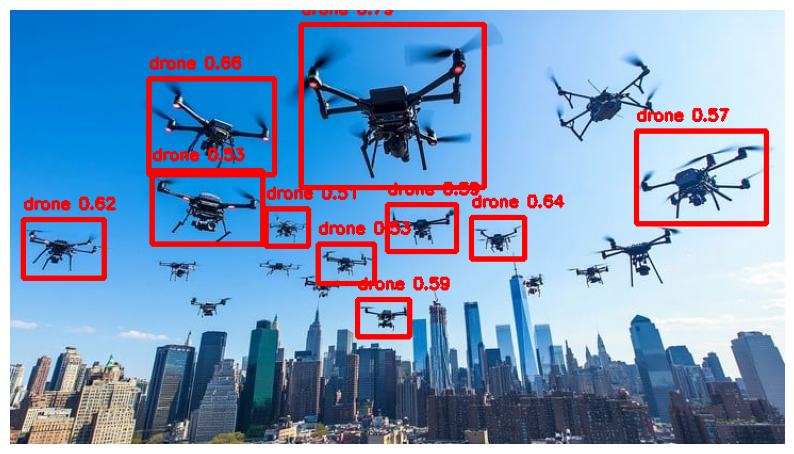

In [ ]:
# Display the resulting image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

#ลองแบบวิดิโอ

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os

def run_auto_input(file_path, model, output_path="output.mp4"):
    video_exts = [".mp4", ".avi", ".mov", ".mkv"]
    image_exts = [".jpg", ".jpeg", ".png", ".bmp"]

    ext = os.path.splitext(file_path)[1].lower()

    if ext in video_exts:
        print("🎥 ตรวจพบว่าเป็นวิดีโอ")
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            raise FileNotFoundError(f"Cannot open video at {file_path}")

        # ✅ ดึง fps และขนาดเฟรมเพื่อตั้งค่า VideoWriter
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = model(frame_rgb)
            annotated = results[0].plot()

            # ✅ เขียนผลลัพธ์ลงไฟล์
            out.write(annotated)

            # โชว์ทุก 30 เฟรม (กันค้าง)
            if frame_count % 30 == 0:
                cv2_imshow(annotated)

            frame_count += 1

        cap.release()
        out.release()
        print(f"✅ วิดีโอบันทึกเสร็จที่ {output_path}")

    elif ext in image_exts:
        print("🖼️ ตรวจพบว่าเป็นภาพนิ่ง")
        image = cv2.imread(file_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at {file_path}")

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = model(image_rgb)
        annotated = results[0].plot()

        cv2_imshow(annotated)

        # ✅ บันทึกภาพออกมาเป็นไฟล์ใหม่
        save_path = "output.jpg"
        cv2.imwrite(save_path, annotated)
        print(f"✅ ภาพถูกบันทึกที่ {save_path}")

    else:
        raise ValueError("Unsupported file format!")

# ตัวอย่างการเรียกใช้
file_path = "fin.mp4"   # ใส่ได้ทั้ง .jpg หรือ .mp4
run_auto_input(file_path, model, output_path="result.mp4")
